# Calculate distances between specific residues in pdb files

In [1]:
from biopandas.pdb import PandasPdb
from os.path import exists
import numpy as np

PATH_XLS_INTRA_NONRED = 'XLs_intra_nonred.csv'

UNRELAXED_PDB_SUFFIX = '-unrelaxed_model_1.pdb'
RELAXED_PDB_SUFFIX = '-relaxed_model_1.pdb'
PTM_PDB_SUFFIX = '-relaxed_model_1_ptm.pdb'
RESULTS_PKL_SUFFIX = '-result_model_1_ptm.pkl'
PAE_PKL_SUFFIX = '-pae_model_1_ptm.pkl'

XL_THRESHOLD = 30

pdbs = {}


def sanitize_protein(protein_id):
    """Replace / in protein ID with _ for compatibility with file system"""
    return protein_id.replace("/", "_").replace("\xa0", "")


def calculate_dist(pdb, xl):
    """Calculate the distance between residues in the PDB based on the crosslink"""
    # Find the C atom for each residue
    res_1 = pdb.loc[pdb['residue_number'] == xl.Res1]
    res_2 = pdb.loc[pdb['residue_number'] == xl.Res2]

    res_1_coords = res_1[['x_coord', 'y_coord', 'z_coord']].to_numpy()
    res_2_coords = res_2[['x_coord', 'y_coord', 'z_coord']].to_numpy()

    return np.linalg.norm(res_1_coords - res_2_coords)


def read_pdb_ca(pdb_filepath):
    ppdb = PandasPdb().read_pdb(pdb_filepath)  # reads pdb into pandas df
    pdbatom = ppdb.df['ATOM']  # extracts only the atom data type from pdb
    return pdbatom[(pdbatom['atom_name'] == 'CA')]  # selects the only the CA atoms


def read_protein_pdb(protein, pdb_suffix):
    if pdb_suffix not in pdbs:
        pdbs[pdb_suffix] = {}
    elif protein in pdbs[pdb_suffix]:
        return pdbs[pdb_suffix][protein]
    pdbs_with_suffix = pdbs[pdb_suffix]

    pdb_filepath = 'models/' + sanitize_protein(protein) + pdb_suffix
    if not exists(pdb_filepath):
        # print(protein + ' PDB file not found. Skipping...')
        return None
    pdb_ca = read_pdb_ca(pdb_filepath)

    pdbs_with_suffix[protein] = pdb_ca
    return pdb_ca


def fill_xls_from_pdb(protein_name, threshold, pdb, xls):
    xls['af_distance'] = xls.apply(
        lambda x: x.af_distance if x.Protein1 != protein_name else calculate_dist(pdb, x), axis=1)
    return xls[(xls['af_distance'] < threshold) & (xls['Protein1'] == protein_name)]


In [2]:
import pandas as pd
import seaborn as sns
import json

In [3]:
if exists(PATH_XLS_INTRA_NONRED):
    XLs_intra_nonred = pd.read_csv(PATH_XLS_INTRA_NONRED)
else:
    # Read in XL csv file to pandas DF
    XLs = pd.read_csv("Union_XL1_XL2_PurifiedSECa-g_IEXcilia2inject2.3-newpeptidepos.csv", encoding='unicode_escape')

    # Save all intramolecular crosslinks to a new DF
    XLs_intra = XLs.loc[XLs['Protein1'] == XLs['Protein2']]

    # Calculate the XL position in the protein primary sequence
    XLs_intra.loc[:, 'Res1'] = XLs_intra['PepPos1'] + XLs_intra['LinkPos1'] - 1
    XLs_intra.loc[:, 'Res2'] = XLs_intra['PepPos2'] + XLs_intra['LinkPos2'] - 1

    # Removes all XL redundancies
    XLs_intra.loc[:, 'newRes1'] = XLs_intra[["Res1", "Res2"]].max(axis=1)
    XLs_intra.loc[:, 'newRes2'] = XLs_intra[["Res1", "Res2"]].min(axis=1)
    XLs_intra_nonred = XLs_intra.drop_duplicates(subset=['Protein1', 'Protein2', 'newRes1', 'newRes2'], keep="last")

    # Save to file
    XLs_intra_nonred.to_csv(PATH_XLS_INTRA_NONRED)

In [4]:
# Extract XL counts
intra_XL_counts = XLs_intra_nonred['Protein1'].value_counts().reset_index().rename(
    columns={'index': 'Protein1', 'Protein1': 'XL_count'})
XLs_intra_nonred.loc[:, 'af_distance'] = None
XLs_intra_nonred

,Unnamed: 0,Id,Score,Protein1,PepPos1,PepSeq1,LinkPos1,Protein2,PepPos2,PepSeq2,LinkPos2,Res1,Res2,newRes1,newRes2,af_distance
0,13,14,413.29,RSPH4A/6A-2,86,KLLDPLMEGEEDNLAPVGAIGYVPNFMEEAK,1,RSPH4A/6A-2,72,EKYEAVSESFKANK,11,86,82,86,82,None
1,20,21,396.55,ILS1,935,EYNKDLKAAAGNLSAK,7,ILS1,921,AIPNHKLLGQK,6,941,926,941,926,None
2,35,36,369.15,I7LU32,298,TQIHTSYGLNQHKEAISLFR,13,I7LU32,318,KVQGGQK,1,310,318,318,310,None
3,70,71,338.56,CDC27,742,SQKEIEDQKK,3,CDC27,752,KLDEELLR,1,744,752,752,744,None
4,75,76,335.56,IDP2,345,AKLDNNKELDLFCK,7,IDP2,408,KNLVAAKSNL,7,351,414,414,351,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,19421,19422,146.57,IFT52,40,NKEDITYDR,2,IFT52,33,ETYKCGR,4,41,36,41,36,None
3400,19422,19423,155.26,IFT144,965,LNLDKLDNLR,5,IFT144,935,QYAKAK,4,969,938,969,938,None
3401,19424,19425,132.32,CCT5,46,SSLGPKGMDK,6,CCT5,173,VVSKNKR,6,51,178,178,51,None
3402,19425,19426,155.99,IFT81,480,NKTEYDQMLKK,10,IFT81,491,LEKEK,3,489,493,493,489,None


In [5]:
def get_af_xl_counts(protein_xl_counts, threshold, pdb_suffix):
    protein = protein_xl_counts['Protein1']
    pdb_ca = read_protein_pdb(protein, pdb_suffix)
    if pdb_ca is None:
        return None
    return fill_xls_from_pdb(protein, threshold, pdb_ca, XLs_intra_nonred).count()['Id']

In [6]:
intra_XL_counts['af_XL_count'] = intra_XL_counts.apply(lambda x: get_af_xl_counts(x, XL_THRESHOLD, UNRELAXED_PDB_SUFFIX), axis=1)

In [7]:
intra_XL_counts[intra_XL_counts['af_XL_count'].notnull()]

,Protein1,XL_count,af_XL_count
4,PRKG1,38,36.0
5,EEF2,35,25.0
6,MRNC57,34,25.0
9,EMAP5/6-1,30,30.0
10,I7MJ59,30,15.0
...,...,...,...
128,I7MHD4,7,7.0
130,I7M4K0,7,7.0
132,DRH29,7,6.0
138,CCDC81-1,7,6.0


In [8]:
def read_confidence(intra_xl_counts):
    protein = intra_xl_counts['Protein1']

    ranking_filepath = 'rankings/' + sanitize_protein(protein) + '-ranking_debug.json'
    if not exists(ranking_filepath):
        return None

    with open(ranking_filepath) as ranking_file:
        ranking_debug = json.load(ranking_file)
        if 'model_1' in ranking_debug['plddts']:
            return ranking_debug['plddts']['model_1']
        else:
            print('Did not have model_1 plddt (was predicted using Alphafold 2.2):', protein)
            return ranking_debug['plddts']['model_1_pred_0']


intra_XL_counts['confidence'] = intra_XL_counts.apply(lambda x: read_confidence(x), axis=1)

Did not have model_1 plddt (was predicted using Alphafold 2.2): SPAG17
Did not have model_1 plddt (was predicted using Alphafold 2.2): UBXN2A/B


In [9]:
intra_XL_counts['XL_agreement'] = intra_XL_counts['af_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts[intra_XL_counts['af_XL_count'].notnull()]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement
4,PRKG1,38,36.0,78.041609,0.947368
5,EEF2,35,25.0,89.479929,0.714286
6,MRNC57,34,25.0,68.385990,0.735294
9,EMAP5/6-1,30,30.0,76.297715,1.000000
10,I7MJ59,30,15.0,67.924191,0.500000
...,...,...,...,...,...
128,I7MHD4,7,7.0,95.693012,1.000000
130,I7M4K0,7,7.0,NaN,1.000000
132,DRH29,7,6.0,NaN,0.857143
138,CCDC81-1,7,6.0,68.906479,0.857143


In [10]:
intra_XL_counts[intra_XL_counts['XL_agreement'] == 1]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement
9,EMAP5/6-1,30,30.0,76.297715,1.0
13,EARS,24,24.0,91.715565,1.0
14,EMAP5/6-2,22,22.0,75.772186,1.0
21,PRKAR1A,18,18.0,76.863226,1.0
24,HSPA4,17,17.0,85.202522,1.0
26,SARS,17,17.0,86.568760,1.0
30,I7M3K6,15,15.0,77.849084,1.0
40,PGM1,14,14.0,94.200454,1.0
42,CASC1,13,13.0,83.404538,1.0
43,I7M328,13,13.0,89.782138,1.0


<AxesSubplot:xlabel='XL_agreement', ylabel='confidence'>

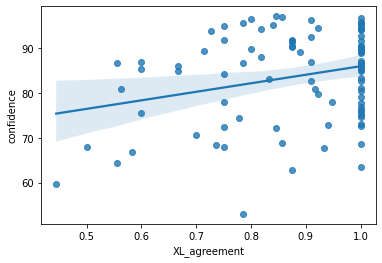

In [11]:
sns.regplot(x=intra_XL_counts['XL_agreement'], y=intra_XL_counts['confidence'])

In [12]:
intra_XL_counts[intra_XL_counts['confidence'] < 70]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement
6,MRNC57,34,25.0,68.385990,0.735294
10,I7MJ59,30,15.0,67.924191,0.500000
31,SPAG17,15,14.0,67.802790,0.933333
38,UBXN2A/B,14,11.0,52.971408,0.785714
51,TRAF3IP1,12,7.0,66.892961,0.583333
58,Q22T19,11,11.0,63.391836,1.000000
85,Q22MP6,9,4.0,59.571289,0.444444
95,SPEF2,9,5.0,64.367416,0.555556
108,EPC1,8,6.0,68.047634,0.750000
110,CDC27,8,7.0,62.773771,0.875000


In [13]:
XLs_intra_nonred[XLs_intra_nonred['af_distance'].notnull()]

,Unnamed: 0,Id,Score,Protein1,PepPos1,PepSeq1,LinkPos1,Protein2,PepPos2,PepSeq2,LinkPos2,Res1,Res2,newRes1,newRes2,af_distance
1,20,21,396.55,ILS1,935,EYNKDLKAAAGNLSAK,7,ILS1,921,AIPNHKLLGQK,6,941,926,941,926,11.486842
3,70,71,338.56,CDC27,742,SQKEIEDQKK,3,CDC27,752,KLDEELLR,1,744,752,752,744,11.888002
4,75,76,335.56,IDP2,345,AKLDNNKELDLFCK,7,IDP2,408,KNLVAAKSNL,7,351,414,414,351,12.968525
5,110,111,324.58,I7LUZ1,315,VICILDKPIPGTKDIPSVQIIIPQR,13,I7LUZ1,128,VPANDKEALQSDLMGLLEK,6,327,133,327,133,17.507300
8,247,248,299.14,Q234E6,487,AQVVEQSLEKHIQNEK,10,Q234E6,603,SKAGTVTR,2,496,604,604,496,18.352268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,19345,19346,138.44,IFT172,556,QLYLYNIKTQTK,8,IFT172,496,LNYHSVKQTK,7,563,502,563,502,15.064587
3355,19355,19356,119.83,IFT172,206,SNKSQVMYSTDSYVVSLAACK,3,IFT172,199,VKSGILR,2,208,200,208,200,10.165514
3370,19378,19379,84.75,DLD,43,AGQLGLKTACVEK,7,DLD,127,NKVDYFVGTGR,2,49,128,128,49,7.841158
3383,19400,19401,132.50,DLD,127,NKVDYFVGTGR,2,DLD,119,GIESLFKK,7,128,125,128,125,4.894888


## Determine overall XL agreement percentage for unrelaxed predictions

In [14]:
af_xls = XLs_intra_nonred[XLs_intra_nonred['af_distance'].notnull()]
print('Total intramolecular XLs in proteins with AF predictions:', len(af_xls))
print('% XL Agreement: {}'.format((af_xls['af_distance'] <= XL_THRESHOLD).mean() * 100))

Total intramolecular XLs in proteins with AF predictions: 1228
% XL Agreement: 86.15635179153095


In [15]:
XLs_intra_nonred['xl_violated'] = XLs_intra_nonred['af_distance'] > XL_THRESHOLD

def get_confidence(protein):
    return intra_XL_counts[intra_XL_counts['Protein1'] == protein].iloc[0]['confidence'] < 70

XLs_intra_nonred['low_protein_confidence'] = None
XLs_intra_nonred['low_protein_confidence'] = XLs_intra_nonred.apply(lambda x: get_confidence(x['Protein1']), axis = 1)

pd.crosstab(XLs_intra_nonred['xl_violated'], XLs_intra_nonred['low_protein_confidence'], normalize='index')

low_protein_confidence,False,True
xl_violated,,
False,0.963203,0.036797
True,0.729412,0.270588


## Compare Unrelaxed vs Relaxed XL counts

In [16]:
top_10_XL_proteins = [
    'PRKG1',
    'EEF2',
    'MRNC57',
    'EMAP5/6-1',
    'I7MJ59',
    'BBC118',
    'FTT18',
    'EARS',
    'EMAP5/6-2',
    'Q23A15'
]

intra_XL_counts['af_relaxed_XL_count'] = intra_XL_counts.apply(lambda x: get_af_xl_counts(x, XL_THRESHOLD, RELAXED_PDB_SUFFIX),
                                                               axis=1)
intra_XL_counts['relaxed_XL_agreement'] = intra_XL_counts['af_relaxed_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['relaxed_vs_unrelaxed_diff'] = intra_XL_counts['af_relaxed_XL_count'] - intra_XL_counts['af_XL_count']
intra_XL_counts[intra_XL_counts['Protein1'].isin(top_10_XL_proteins)]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement,af_relaxed_XL_count,relaxed_XL_agreement,relaxed_vs_unrelaxed_diff
4,PRKG1,38,36.0,78.041609,0.947368,35.0,0.921053,-1.0
5,EEF2,35,25.0,89.479929,0.714286,25.0,0.714286,0.0
6,MRNC57,34,25.0,68.385990,0.735294,24.0,0.705882,-1.0
9,EMAP5/6-1,30,30.0,76.297715,1.000000,30.0,1.000000,0.0
10,I7MJ59,30,15.0,67.924191,0.500000,17.0,0.566667,2.0
11,BBC118,25,15.0,85.481704,0.600000,15.0,0.600000,0.0
12,FTT18,25,21.0,95.138586,0.840000,21.0,0.840000,0.0
13,EARS,24,24.0,91.715565,1.000000,24.0,1.000000,0.0
14,EMAP5/6-2,22,22.0,75.772186,1.000000,22.0,1.000000,0.0
16,Q23A15,20,12.0,75.527561,0.600000,14.0,0.700000,2.0


In [17]:
intra_XL_counts[intra_XL_counts['Protein1'].isin(top_10_XL_proteins)]['relaxed_vs_unrelaxed_diff'].mean()

0.2

# Examine example proteins - outliers from confidence / XL violation plot

## Compare Relaxed to Relaxed PTM XL counts for example proteins

In [18]:
intra_XL_counts['af_ptm_XL_count'] = intra_XL_counts.apply(lambda x: get_af_xl_counts(x, XL_THRESHOLD, PTM_PDB_SUFFIX), axis=1)
intra_XL_counts['ptm_XL_agreement'] = intra_XL_counts['af_ptm_XL_count'] / intra_XL_counts['XL_count']
intra_XL_counts['ptm_vs_relaxed_diff'] = intra_XL_counts['af_ptm_XL_count'] - intra_XL_counts['af_relaxed_XL_count']
intra_XL_counts[intra_XL_counts['ptm_XL_agreement'].notnull()]

,Protein1,XL_count,af_XL_count,confidence,XL_agreement,af_relaxed_XL_count,relaxed_XL_agreement,relaxed_vs_unrelaxed_diff,af_ptm_XL_count,ptm_XL_agreement,ptm_vs_relaxed_diff
4,PRKG1,38,36.0,78.041609,0.947368,35.0,0.921053,-1.0,36.0,0.947368,1.0
5,EEF2,35,25.0,89.479929,0.714286,25.0,0.714286,0.0,25.0,0.714286,0.0
6,MRNC57,34,25.0,68.385990,0.735294,24.0,0.705882,-1.0,24.0,0.705882,0.0
10,I7MJ59,30,15.0,67.924191,0.500000,17.0,0.566667,2.0,17.0,0.566667,0.0
11,BBC118,25,15.0,85.481704,0.600000,15.0,0.600000,0.0,15.0,0.600000,0.0
12,FTT18,25,21.0,95.138586,0.840000,21.0,0.840000,0.0,21.0,0.840000,0.0
16,Q23A15,20,12.0,75.527561,0.600000,14.0,0.700000,2.0,13.0,0.650000,-1.0
19,KARS,18,12.0,84.987008,0.666667,12.0,0.666667,0.0,12.0,0.666667,0.0
29,I7M6H8,16,9.0,81.030202,0.562500,9.0,0.562500,0.0,9.0,0.562500,0.0
51,TRAF3IP1,12,7.0,66.892961,0.583333,7.0,0.583333,0.0,7.0,0.583333,0.0


## Examine PAE pattern to extract cohesive regions

### Replace unrelaxed Alphafold distances with distances from PTM predictions

In [19]:
pae_proteins = [
    "PRKG1",
    "EEF2",
    "MRNC57",
    "I7MJ59",
    "FTT18",
    "BBC118",
    "Q23A15",
    "KARS",
    "I7M6H8",
    "TRAF3IP1",
    "EIF4A",
    "SPEF2",
    "Q22MP6",
    "RPS0"
]

for pae_protein in pae_proteins:
    pdb_ca = read_protein_pdb(pae_protein, PTM_PDB_SUFFIX)
    if pdb_ca is None:
        print(pae_protein)
    fill_xls_from_pdb(pae_protein, XL_THRESHOLD, pdb_ca, XLs_intra_nonred)

### Plot pairwise Predicted Aligned Error values as heatmap with XL violations and agreements overlayed

In [20]:
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.morphology import square
from skimage.segmentation import watershed
from skimage.filters import rank
from skimage.util import img_as_ubyte


def plot_plddt(protein):
    sanitized_protein = sanitize_protein(protein)
    results = pd.read_pickle('results/' + sanitized_protein + RESULTS_PKL_SUFFIX)

    plddt = results['plddt']

    plt.figure(figsize=[16, 6])
    plt.subplot(1, 2, 1)
    plt.plot(plddt)
    plt.title('Predicted LDDT')
    plt.xlabel('Residue')
    plt.ylabel('pLDDT')


def plot_pae(protein, xl_thresholds):
    sanitized_protein = sanitize_protein(protein)

    results = pd.read_pickle('pae/' + sanitized_protein + PAE_PKL_SUFFIX)

    pae = results['predicted_aligned_error']

    protein_xls = XLs_intra_nonred.loc[XLs_intra_nonred['Protein1'] == protein]

    figure = plt.figure(figsize=(5, 5))
    figure.patch.set_facecolor('white')
    subplot_index = 1

    for xl_threshold in xl_thresholds:
        plt.subplot(1, len(xl_thresholds), subplot_index)
        subplot_index += 1

        protein_xls_agreed = protein_xls[protein_xls['af_distance'] <= xl_threshold]
        protein_xls_missed = protein_xls[protein_xls['af_distance'] > xl_threshold]

        plt.imshow(pae, cmap='gray', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.scatter(protein_xls_agreed['newRes1'], protein_xls_agreed['newRes2'], marker='o', facecolor='none',
                    edgecolor='darkblue', linewidths=2)
        plt.scatter(protein_xls_missed['newRes1'], protein_xls_missed['newRes2'], marker='x', c='darkred', linewidths=2)

        plt.title(protein + ' Predicted Aligned Error, XL Threshold ' + str(xl_threshold))
        plt.xlabel('Scored residue')
        plt.ylabel('Aligned residue')


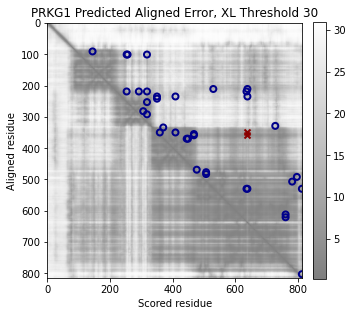

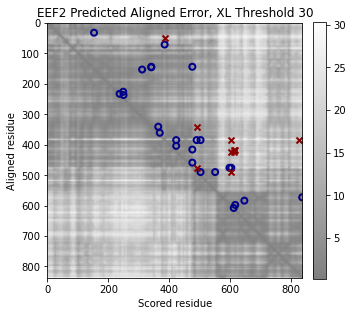

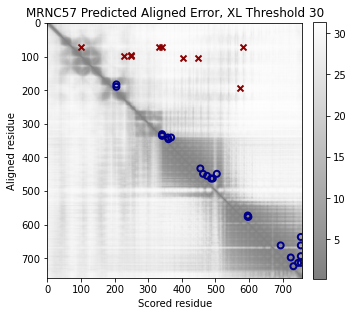

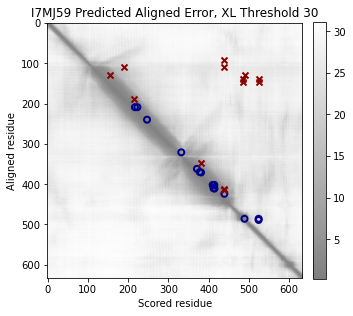

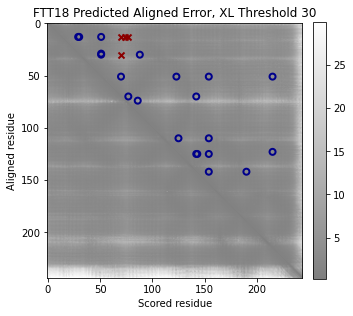

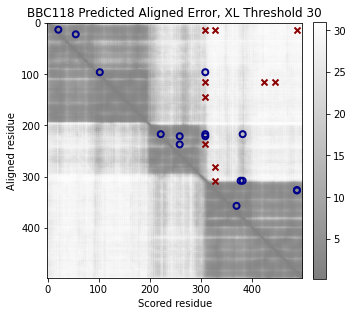

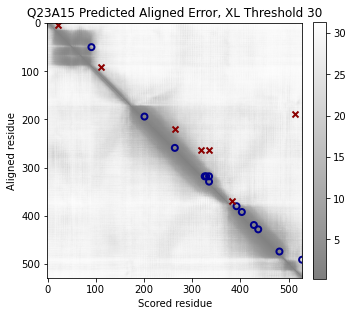

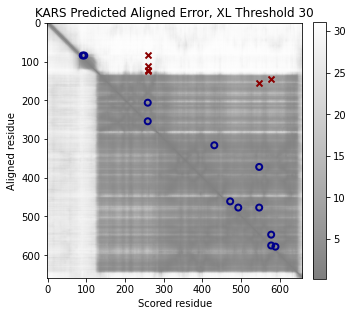

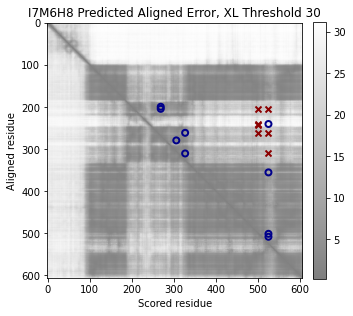

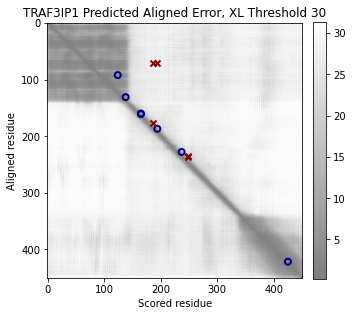

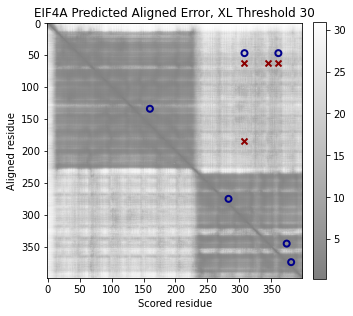

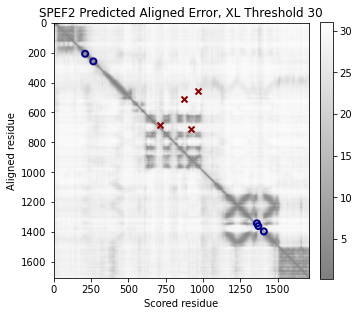

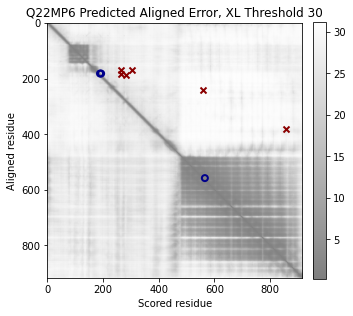

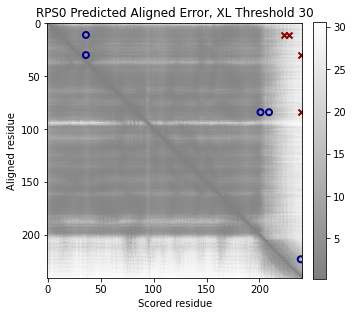

In [21]:
thresholds = [30]

for pae_protein in pae_proteins:
    plot_pae(pae_protein, thresholds)

## Identify cohesive regions from PAE heatmap using watershed segmentation

In [22]:
from collections import Counter

show_watershed_process = True


def make_symmetric(pae):
    pae = np.array(pae)
    return (pae + pae.transpose()) / 2


def predict_watershed(name, pae, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint,
                      repeat_denoise, remove_thin_regions, region_edge_threshold):
    img_pae_original = (pae - np.min(pae)) / (np.max(pae) - np.min(pae))

    # Make symmetric - easier to determine segmentation
    pae = make_symmetric(pae)

    img_pae = (pae - np.min(pae)) / (np.max(pae) - np.min(pae))
    image = img_as_ubyte(img_pae)

    # denoise image
    denoised = rank.median(image, square(denoise_footprint))

    if repeat_denoise > 1:
        for i in range(0, repeat_denoise):
            denoised = rank.median(denoised, square(denoise_footprint))

    # find continuous region (low gradient -
    # where less than marker_threshold for this image) --> markers
    # square(marker_footprint) is used here to get a more smooth image
    markers = rank.gradient(denoised, square(marker_footprint)) < marker_threshold
    markers = ndi.label(markers)[0]

    # local gradient (square(gradient_footprint) is used to keep edges thin)
    gradient = rank.gradient(denoised, square(gradient_footprint))

    # process the watershed
    labels = watershed(gradient, markers)

    diagonal = np.diagonal(np.array(labels))
    region_labels = diagonal.copy()

    if remove_thin_regions:
        for i in range(0, len(region_labels)):
            label = region_labels[i]
            before = 0
            after = 0
            if i >= region_edge_threshold:
                before = labels[i, i - region_edge_threshold]
            if i + region_edge_threshold < region_labels.shape[0]:
                after = labels[i, i + region_edge_threshold]
            if before != label and after != label:
                region_labels[i] = 0

    regions_count = np.bincount(region_labels)
    region_count_threshold = 30
    segment_background_labels = []
    # If there are "background" non-region labels, mark as 0
    if len(regions_count) > 1:
        segment_background_labels.append(labels[0, len(region_labels) - 1])
        segment_background_labels.append(labels[len(region_labels) - 1, 0])
    for i in range(0, len(region_labels)):
        if region_labels[i] in segment_background_labels:
            region_labels[i] = 0
        if regions_count[region_labels[i]] < region_count_threshold:
            region_labels[i] = 0

    # Fill empty gaps in labeled regions
    regions_counter = Counter(region_labels)
    fill_label = None
    for i in range(0, len(region_labels)):
        if region_labels[i] != 0:
            # Determine region label and count down to end of region
            fill_label = region_labels[i]
            regions_counter[fill_label] = regions_counter[fill_label] - 1
            if regions_counter[fill_label] == 0:
                fill_label = None
        elif fill_label is not None:
            # Fill in 0s with label
            region_labels[i] = fill_label

    regions_mat = np.array([i if i == j else 0 for i in region_labels for j in region_labels]).reshape(
        region_labels.shape[0], region_labels.shape[0])

    # display results
    subplots = 7 if show_watershed_process else 1
    fig, axes = plt.subplots(nrows=1, ncols=subplots, figsize=(subplots * 5, 6),
                             sharex=True, sharey=True)
    fig.patch.set_facecolor('white')
    fig.suptitle(name + ' Watershed Segmentation')

    cmap = plt.cm.get_cmap("viridis").copy()
    cmap.set_bad(color='black')

    regions_mat = np.ma.masked_where(regions_mat == 0, regions_mat)

    if show_watershed_process:
        ax = axes.ravel()

        ax[0].imshow(image, cmap=plt.cm.gray)
        ax[0].set_title("Symmetric")

        ax[1].imshow(denoised, cmap=plt.cm.gray)
        ax[1].set_title("Denoised")

        ax[2].imshow(gradient, cmap=plt.cm.nipy_spectral)
        ax[2].set_title("Local Gradient")

        ax[3].imshow(markers)
        ax[3].set_title("Markers")

        ax[4].imshow(labels)
        ax[4].set_title("Segmented")

        ax[5].imshow(regions_mat, cmap=cmap)
        ax[5].set_title("regions")

        ax[6].imshow(regions_mat, cmap=cmap, alpha=1 - img_pae_original)
        ax[6].set_title("Original with regions Overlayed")
        ax[6].set_xlabel("Scored Residue")
        ax[6].set_ylabel("Aligned Residue")

    else:
        ax = axes

        ax.imshow(regions_mat, cmap=cmap, alpha=1 - img_pae_original)
        ax.set_title("Original with regions Overlayed")
        ax.set_xlabel("Scored Residue")
        ax.set_ylabel("Aligned Residue")

    fig.tight_layout()
    plt.show()

    print(np.unique(labels), 'original labels')
    print(np.unique(region_labels), 'regions')

    return region_labels


def predict_watershed_for_proteins(proteins_with_parameters):
    labels = {}
    for pae_protein in proteins_with_parameters:
        (protein, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint, repeat_denoise,
         remove_thin_regions, region_edge_threshold) = pae_protein
        results = pd.read_pickle('pae/' + sanitize_protein(protein) + PAE_PKL_SUFFIX)
        pae = results['predicted_aligned_error']

        labels[protein] = predict_watershed(protein, pae, denoise_footprint, marker_footprint, marker_threshold, gradient_footprint, repeat_denoise, remove_thin_regions, region_edge_threshold)

    return labels


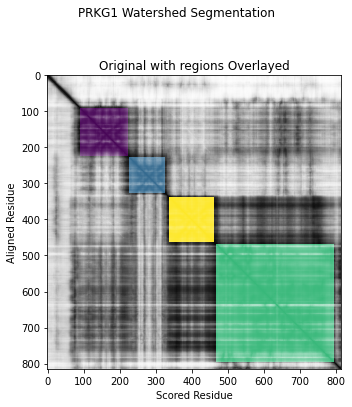

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] original labels
[0 4 5 6 7] regions


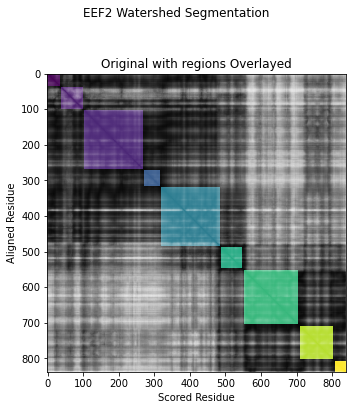

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77] original labels
[ 1  6  8 21 30 44 48 64 72] regions


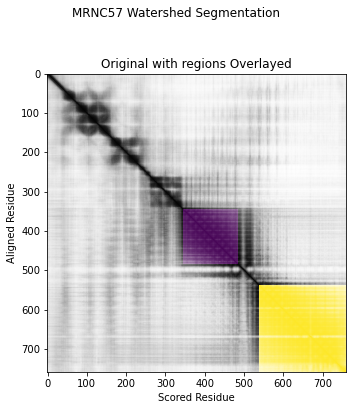

[1 2 3 4 5 6] original labels
[0 5 6] regions


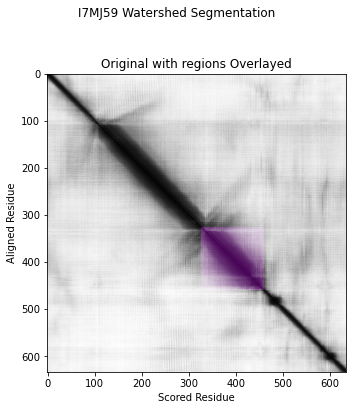

[1 2 3 4 5 6 7 8] original labels
[0 8] regions


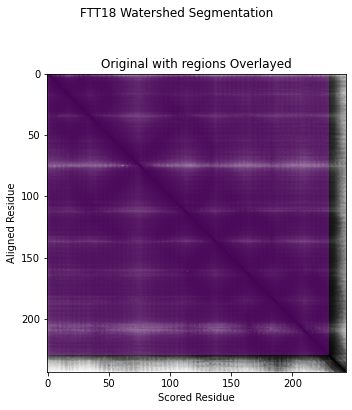

[ 1  2  3  4  5  6  7  8  9 10 11 12 13] original labels
[0 1] regions


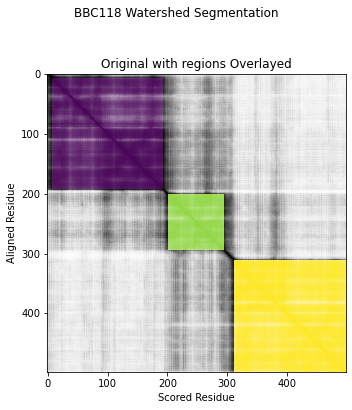

[ 1  2  3  4  5  6  7  8  9 10] original labels
[ 0  4  9 10] regions


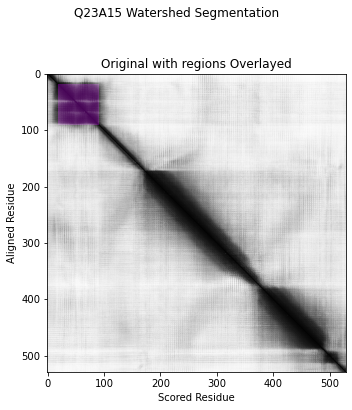

[ 1  2  3  4  5  6  7  8  9 10 11] original labels
[0 2] regions


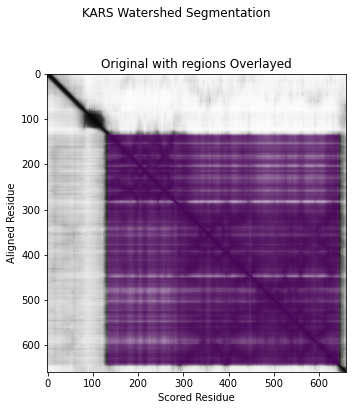

[1 2 3] original labels
[0 3] regions


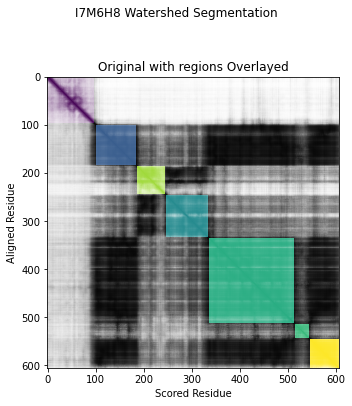

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] original labels
[ 1  7 11 14 15 19 22] regions


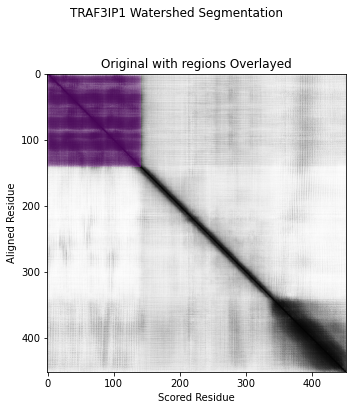

[1 2 3 4] original labels
[0 1] regions


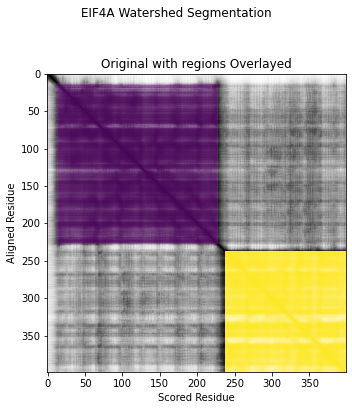

[1 2 3 4] original labels
[0 2 3] regions


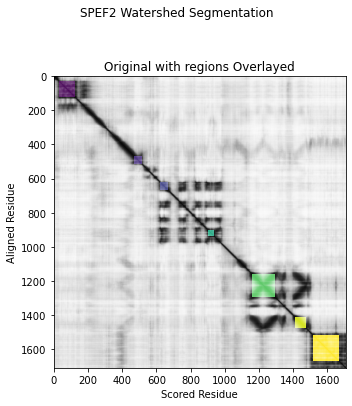

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202] original labels
[  0   4  29  42 117 143 178 191] regions


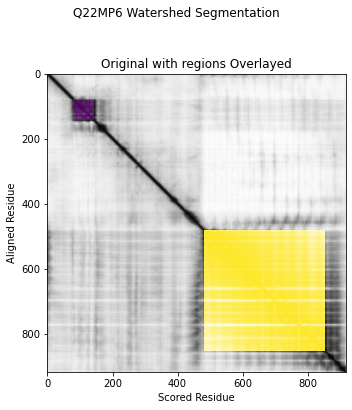

[1 2 3 4 5 6 7 8] original labels
[0 3 5] regions


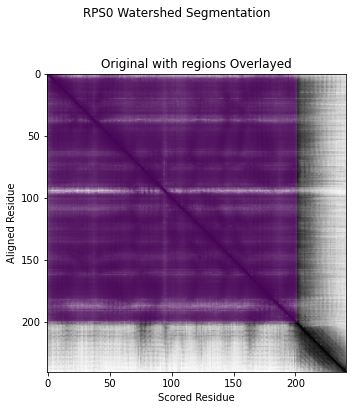

[1 2 3 4] original labels
[0 1] regions


In [23]:
# denoise_footprint, marker_footprint, marker_threshold, gradient_footprint, repeat_denoise, region_edge_threshold
pae_proteins_watershed_settings = [
    ("PRKG1", 12, 50, 115, 10, 1, True, 20), # good
    ("EEF2", 15, 40, 30, 3, 3, False, 5), # okay
    ("MRNC57", 15, 65, 105, 10, 2, True, 50), # okay
    ("I7MJ59", 10, 50, 140, 10, 1, True, 40), # good
    ("FTT18", 10, 10, 40, 4, 1, True, 40), # good
    ("BBC118", 10, 50, 100, 5, 1, True, 20), # good
    ("Q23A15", 10, 50, 150, 10, 1, True, 40), # good
    ("KARS", 10, 45, 150, 10, 1, True, 40), # good
    ("I7M6H8", 10, 40, 55, 5, 1, False, 20), #okay
    ("TRAF3IP1", 10, 50, 150, 10, 1, True, 40), # good
    ("EIF4A", 10, 50, 150, 10, 1, True, 40), # good
    ("SPEF2", 10, 10, 40, 20, 1, True, 35), # bad
    ("Q22MP6", 15, 60, 95, 10, 1, True, 40), # good
    ("RPS0", 10, 50, 150, 10, 1, True, 40) # good
]

show_watershed_process = False
labels = predict_watershed_for_proteins(pae_proteins_watershed_settings)

### Corresponding proteins in Uniprot

[I7M6H8](https://www.uniprot.org/uniprot/I7M6H8)
* Domain (IMPDH) 104-600

[Q23A15](https://www.uniprot.org/uniprot/Q23A15)
* Disordered 1 - 20
* Disordered 93 - 157
* Compositional Bias (Polar residues) 96 - 141
* Disordered 242 - 278
* Disordered 324 - 364
* Disordered 395 - 441
* Coiled Coil 503 - 523

[Q22MP6](https://www.uniprot.org/uniprot/Q22MP6)
* Disordered 1-38
* Disordered 401 - 420
* Coiled Coil 156 - 176
* Domain (Protein Kinase) 116 - 455
* Repeat (TPR) 606 - 639

[I7MJ59](https://www.uniprot.org/uniprot/I7MJ59)
* Disordered 1-41
* Coiled Coil 119 - 139
* Coiled Coil 150 - 194
* Coiled Coil 203 - 237
* Coiled Coil 247 - 267
* Coiled Coil 332 - 362
* Disordered 496 - 515
* Disordered 614 - 633

## Classify agreements / violations as intra-region or inter-region

In [24]:
def is_intraregion(region_labels, res1, res2):
    return region_labels[res1] != 0 and region_labels[res1] == region_labels[res2]

# Re-calculate violated XLs based on the PTM distances
XLs_intra_nonred['xl_violated'] = XLs_intra_nonred['af_distance'] > XL_THRESHOLD
XLs_intra_nonred['is_intraregion'] = None

for protein in pae_proteins:
    region_labels = labels[protein]
    XLs_intra_nonred['is_intraregion'] = XLs_intra_nonred.apply(lambda x: x['is_intraregion'] if x['Protein1'] != protein else is_intraregion(region_labels, x['newRes1'], x['newRes2']), axis = 1)

pd.crosstab(XLs_intra_nonred['xl_violated'], XLs_intra_nonred['is_intraregion'], normalize='index')

is_intraregion,False,True
xl_violated,,
False,0.454545,0.545455
True,0.902174,0.097826


In [25]:
# ChimeraX color by region - do manually
# IMP - can try out for fun
# ACBD7, UBXN2A/B, SPAG17, IDP2

In [26]:
# TODO:
# do render_chimerax.py for all the unrelaxed proteins to show violations/agreements
# do render_chimerax.py for the PTM proteins colored by region label, show XLs and color by violation/agreement _and_ inter/intraregion